In [1]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import os
import folium
from matplotlib import pyplot as plt

In [25]:
def print_metadata(image_path):
    print(f"\nExtracting metadata from {image_path}\n")
    image = Image.open(image_path)
    metadata = image._getexif()
    if metadata:
        for tag_id, value in metadata.items():
            tag_name = TAGS.get(tag_id, tag_id)
            print(f"{tag_name}: {value}")
    else:
        print("No EXIF metadata found.")

def print_gps_info(image_path):
    print(f"\nExtracting GPS info from {image_path}\n")
    image = Image.open(image_path)
    exif_data = image._getexif()
    if exif_data:
        for tag_id in exif_data:
            tag_name = TAGS.get(tag_id, tag_id)
            if tag_name == "GPSInfo":
                gps_data = exif_data[tag_id]
                for gps_tag in gps_data:
                    gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                    print(f"{gps_tag_name}: {gps_data[gps_tag]}")
    else:
        print("No EXIF metadata found.")


cwd = os.getcwd()
"""folders = os.listdir(cwd)
folders = [os.path.join(cwd, folder) for folder in folders if os.path.isdir(os.path.join(cwd, folder))]"""
#print(folders)
"""for folder in folders:
    if folder == ".git":
        continue
    print(folder)
    subfolders = os.listdir(folder)
    subfolders = [os.path.join(folder, subfolder) for subfolder in subfolders if os.path.isdir(os.path.join(folder, subfolder))]
    files = os.listdir(subfolders[0])
    print(files)
    for file in files:
        if file.endswith(".JPG"):
            print_metadata(os.path.join(subfolders[0], file))
            print_gps_info(os.path.join(subfolders[0], file))
            print()"""

folder = os.path.join(cwd, "Gabe")
folders = os.listdir(folder)
print(folders)
folders = [os.path.join(folder, f) for f in folders if os.path.isdir(os.path.join(folder, f))]
print(folders)
folder = folders[0]
files = os.listdir(folder)
print(files)
for file in files:
    if file.endswith(".JPG") or file.endswith(".jpg"):
        print_metadata(os.path.join(folder, file))
        print_gps_info(os.path.join(folder, file))
        print()

['General', 'Organic', 'Recycling']
['d:\\Uni\\Year 3\\CV\\Assignment\\Gabe\\General', 'd:\\Uni\\Year 3\\CV\\Assignment\\Gabe\\Organic', 'd:\\Uni\\Year 3\\CV\\Assignment\\Gabe\\Recycling']
['IMG_20250104_070435.jpg', 'IMG_20250104_070450.jpg', 'IMG_20250104_070453.jpg', 'IMG_20250104_070512.jpg', 'IMG_20250104_070635.jpg', 'IMG_20250104_070727.jpg', 'IMG_20250104_070737.jpg', 'IMG_20250104_070809.jpg', 'IMG_20250104_070812.jpg', 'IMG_20250104_070837.jpg', 'IMG_20250104_071017.jpg', 'IMG_20250104_071123.jpg', 'IMG_20250104_071236.jpg', 'IMG_20250104_071445.jpg', 'IMG_20250104_071502.jpg', 'IMG_20250104_071510.jpg', 'IMG_20250104_071553.jpg', 'IMG_20250104_071641.jpg', 'IMG_20250104_071750.jpg', 'IMG_20250104_071752.jpg', 'IMG_20250104_071804.jpg', 'IMG_20250104_071807.jpg', 'IMG_20250104_071826.jpg', 'IMG_20250104_071829.jpg', 'IMG_20250104_071838.jpg', 'IMG_20250104_071851.jpg']

Extracting metadata from d:\Uni\Year 3\CV\Assignment\Gabe\General\IMG_20250104_070435.jpg

ImageWidth: 1466

In [31]:
def get_geotags(image_path):
    image = Image.open(image_path)
    metadata = image._getexif()
    if not metadata:
        return None

    gps_info = metadata.get(34853)  # GPSInfo tag ID
    if gps_info:
        geotags = {GPSTAGS.get(tag, tag): value for tag, value in gps_info.items()}
        return geotags
    return None

def convert_to_degrees(value):
    d, m, s = value
    return d + (m / 60.0) + (s / 3600.0)

def get_coordinates(geotags):
    lat = convert_to_degrees(geotags["GPSLatitude"])
    if geotags["GPSLatitudeRef"] == "S":
        lat = -lat

    lon = convert_to_degrees(geotags["GPSLongitude"])
    if geotags["GPSLongitudeRef"] == "W":
        lon = -lon

    return lat, lon

def find_center(coordinates):
    # Find the center of a set of coordinates
    lats = [coord[0] for coord in coordinates]
    lons = [coord[1] for coord in coordinates]
    return sum(lats) / len(coordinates), sum(lons) / len(coordinates)

def create_map(markers, classes, class2col, zoom=10):
    map = folium.Map(location=find_center(markers), zoom_start=zoom)
    for coord, cls in zip(markers, classes):
        folium.Marker(
            location=coord,
            popup=cls,
            icon=folium.Icon(color=class2col[cls])
        ).add_to(map)
    return map

# Create a map with markers for each image
coordinates = []
classes = []

class2col = {"General": "blue", "Organic": "red", "Recycling": "green"}

camera_models = []

cwd = os.getcwd()
folders = os.listdir(cwd)
folders = [os.path.join(cwd, folder) for folder in folders if os.path.isdir(os.path.join(cwd, folder))]

for folder in folders:
    print (folder)
    if folder.endswith(".git"):
        print("Skipping .git folder")
        continue
    for subfolder in os.listdir(folder):
        print(subfolder)
        if not os.path.isdir(os.path.join(folder, subfolder)):
            continue
        files = os.listdir(os.path.join(folder, subfolder))
        print(files)
        for file in files:
            if file.endswith(".JPG") or file.endswith(".jpg"):
                geotags = get_geotags(os.path.join(folder, subfolder, file))
                image = Image.open(os.path.join(folder, subfolder, file))
                metadata = image._getexif()
                if metadata:
                    camera_model = metadata.get(272, "Unknown")
                    camera_models.append(camera_model)
                    classes.append(subfolder.split("\\")[-1])

                if geotags:
                    coordinates.append(get_coordinates(geotags))
                    
map = create_map(coordinates, classes, class2col, 15)

map


d:\Uni\Year 3\CV\Assignment\.git
Skipping .git folder
d:\Uni\Year 3\CV\Assignment\Gabe
General
['IMG_20250104_070435.jpg', 'IMG_20250104_070450.jpg', 'IMG_20250104_070453.jpg', 'IMG_20250104_070512.jpg', 'IMG_20250104_070635.jpg', 'IMG_20250104_070727.jpg', 'IMG_20250104_070737.jpg', 'IMG_20250104_070809.jpg', 'IMG_20250104_070812.jpg', 'IMG_20250104_070837.jpg', 'IMG_20250104_071017.jpg', 'IMG_20250104_071123.jpg', 'IMG_20250104_071236.jpg', 'IMG_20250104_071445.jpg', 'IMG_20250104_071502.jpg', 'IMG_20250104_071510.jpg', 'IMG_20250104_071553.jpg', 'IMG_20250104_071641.jpg', 'IMG_20250104_071750.jpg', 'IMG_20250104_071752.jpg', 'IMG_20250104_071804.jpg', 'IMG_20250104_071807.jpg', 'IMG_20250104_071826.jpg', 'IMG_20250104_071829.jpg', 'IMG_20250104_071838.jpg', 'IMG_20250104_071851.jpg']
Organic
['IMG_20250106_071828.jpg', 'IMG_20250106_071920.jpg', 'IMG_20250106_071938.jpg', 'IMG_20250106_071953.jpg', 'IMG_20250106_072022.jpg', 'IMG_20250106_072028.jpg', 'IMG_20250106_072039.jpg', 'IMG

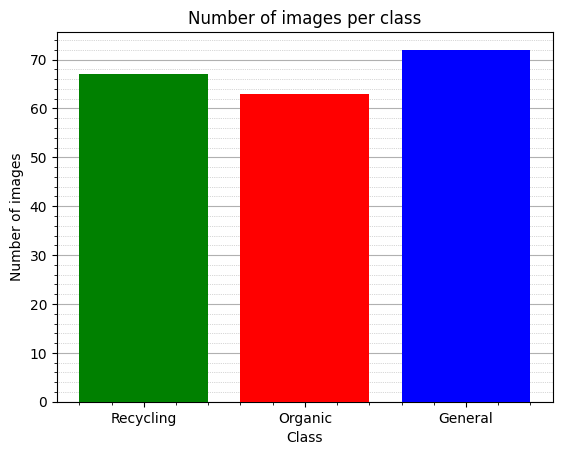

In [32]:
# Create a histogram of the classes
class_counts = {cls: classes.count(cls) for cls in set(classes)}
plt.bar(class_counts.keys(), class_counts.values(), color=[class2col[cls] for cls in class_counts.keys()], zorder=3)
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per class")
plt.show()

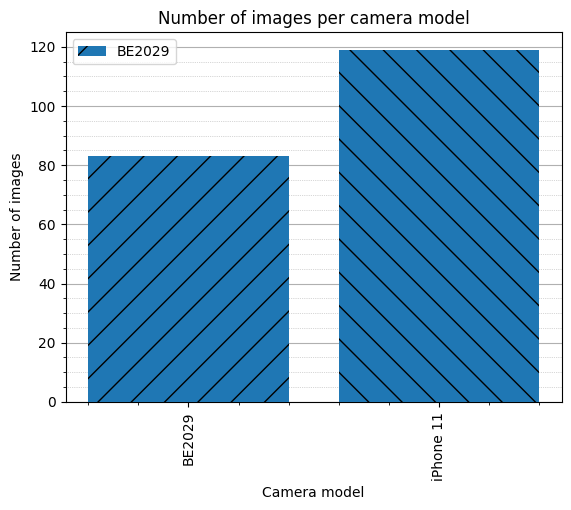

In [40]:
# Create a histogram of the camera models
patterns = ['/', '\\', '|', '-'] # Hopefully enough patterns for the number of models
model2pattern = {model: patterns[i] for i, model in enumerate(set(camera_models))}
#camera_model_set = set(camera_models)
camera_model_counts = {model: camera_models.count(model) for model in set(camera_models)}
plt.bar(camera_model_counts.keys(), camera_model_counts.values(), hatch=[model2pattern[model] for model in camera_model_counts.keys()], zorder=3)
plt.xlabel("Camera model")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per camera model")
plt.xticks(rotation=90)
plt.legend(camera_model_counts.keys())
plt.show()

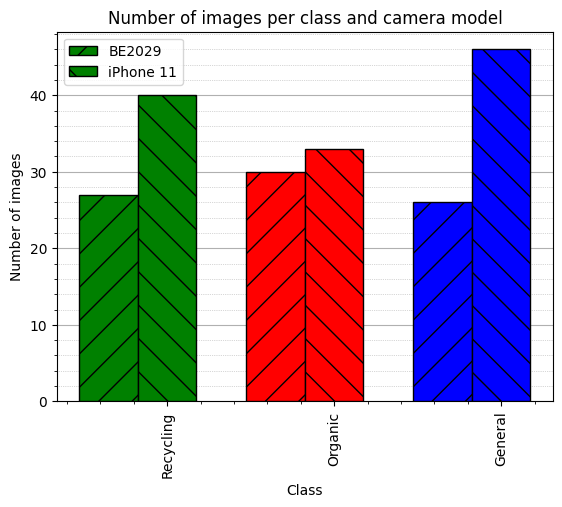

In [37]:
# Split class histogram by camera models

class_counts_per_model = {model: {cls: 0 for cls in set(classes)} for model in set(camera_models)}
for i, model in enumerate(camera_models):
    class_counts_per_model[model][classes[i]] += 1



fig, ax = plt.subplots()
width = 0.35
x = range(len(class_counts_per_model[camera_models[0]]))
for i, model in enumerate(set(camera_models)):
    bar = ax.bar(
        [pos + i * width for pos in x],
        class_counts_per_model[model].values(),
        width,
        label=model,
        color=[class2col[cls] for cls in class_counts_per_model[model].keys()],
        hatch=model2pattern[model],
        edgecolor='black',
        zorder=3
    )

ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(class_counts_per_model[camera_models[0]].keys())
ax.legend()
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.minorticks_on()
plt.grid(axis="y", which="major")
plt.grid(axis="y", which="minor", linestyle=":", linewidth="0.5")
plt.title("Number of images per class and camera model")
plt.xticks(rotation=90)
plt.show()

